In [ ]:
from typing import List

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp
import jaxley as jx
from jaxley_mech.utils import prettify

import jax
jax.config.update("jax_enable_x64", True)

import seaborn as sns
sns.set_style("whitegrid")

from jaxley_mech.channels.benav12 import Ca_T, K_IR

Imported successfully!


In [2]:
def plot_iv_curves_ramp(channels: List[jx.channels], 
                        v_start: float = -100,  
                        v_end: float = 50,  
                        v_step_increase: float = 0.05,  
                        measurements_per_step: int = 1, 
                        title_str: str = None) -> None:
    """
    Plot I-V curves for a list of channels by setting a holding voltage and
    then applying a ramp voltage. Measure the current at each voltage step. 
    You can set the number of measurements per step to increase the resolution.
    The mean is always taken over the number of measurements per step.
    Before the holding voltage and after the ramp voltage padding is applied to
    eliminate the edge effects. The I-V curve is plotted for each channel.
    
    channels: List[jx.channels]     - List of channels to plot I-V curves for
    v_start: float                  - Start voltage of the ramp in mV
    v_end: float                    - End voltage of the ramp in mV
    v_step_increase: float          - Voltage step increase in mV
    measurements_per_step: int      - Number of measurements per step
    title_str: str                  - Title of the figure
    """

    # Calculate the time step, which is the inverse of how many measurements are 
    # taken per step, so that the total time is the index of the taken measurement
    dt = 1 / measurements_per_step
    
    # Calculate the padding steps based on the voltage step increase
    padding_time = 10
    padding_steps = int(padding_time / v_step_increase)

    # Define the number of voltage steps and create the ramp by repeating the voltage
    # steps for the number of measurements per step
    num_points = int((v_end - v_start) / v_step_increase)
    v_ramp = jnp.repeat(jnp.linspace(v_start, v_end, num_points), measurements_per_step)
    
    # Apply padding to the voltage ramp
    v_ramp = jnp.pad(v_ramp, (padding_steps, padding_steps), 'edge')
    
    # Total time with padding
    total_time_pad = (len(v_ramp) - 1) * dt

    # Initialize cell components
    compartment = jx.Compartment()
    branch = jx.Branch(compartment, nseg=1)
    cell = jx.Cell(branch, parents=[-1])

    # Set cell parameters
    params = {
        "length": 5.0,
        "radius": 2.5,
        "capacitance": 10,
        "v": -80  # Assuming v_rest is -80 as per the function call
    }
    for name, param in params.items():
        cell.set(name, param)
    
    # Define variables to record
    to_records = ['v']
    for channel in channels:
        cell.insert(channel)
        cell.init_states()
        
        # Add current names to records, excluding specific channels
        if channel._name not in ['CaPump', 'CaNernstReversal']:
            to_records.append(channel.current_name)

    # Initialize the array to store averaged currents at each voltage step
    currents = np.zeros((len(channels), num_points))

    # Set up clamp and recording
    cell.delete_recordings()
    cell.delete_stimuli()
    cell.clamp('v', v_ramp, False)
    for rec in to_records:
        cell.record(rec, verbose=False)

    # Integrate with the refined time step
    s = jx.integrate(cell, delta_t=dt, t_max=total_time_pad)
    s = prettify(s, to_records, dt)

    # Remove padding for analysis
    s_pad = {}
    for rec in to_records:
        s_pad[rec] = s[rec][padding_steps:-padding_steps]
    s_pad['time'] = s['time'][padding_steps:-padding_steps] - (padding_steps / measurements_per_step)
    
    # Calculate the average current at each voltage step
    for i, rec in enumerate(to_records[1:]):
        if 'i' in rec:
            # Convert nA to pA by multiplying with 1e3
            current_values = s_pad[rec] * 1e3
            
            # Calculate the mean current for each voltage step
            for j in range(num_points):
                # Use the start and end index to calculate the mean current
                start_idx = j * measurements_per_step
                end_idx = (j + 1) * measurements_per_step
                currents[i, j] = np.mean(current_values[start_idx:end_idx])

    # Plot I-V curves for each channel
    fig, axes = plt.subplots(1, len(channels), figsize=(10, 5 * len(channels)))
    if len(channels) == 1:
        axes = [axes]

    for idx_channel, channel in enumerate(channels):
        axes[idx_channel].plot(v_ramp[padding_steps:-padding_steps:measurements_per_step], currents[idx_channel, :], linestyle='-', label=f'{channel._name}')
        axes[idx_channel].set_xlabel('Ramp Voltage (mV)')
        axes[idx_channel].set_ylabel('Current (pA)')
        if title_str is not None:
            axes[idx_channel].set_title(f'{title_str}')
        else:
            axes[idx_channel].set_title(f'I-V Curve for {channel._name}', fontsize=16)
        if len(channels) > 1:
            axes[idx_channel].legend()
        axes[idx_channel].yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
        axes[idx_channel].xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
        axes[idx_channel].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    # Plot voltage clamp for reference
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(s_pad['time'], s_pad['v'], linestyle='-', label='Vclamp')
    ax.set_xlabel('Index of Voltage step')
    ax.set_ylabel('Voltage (mV)')
    ax.set_title('Voltage Clamp', fontsize=16)
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

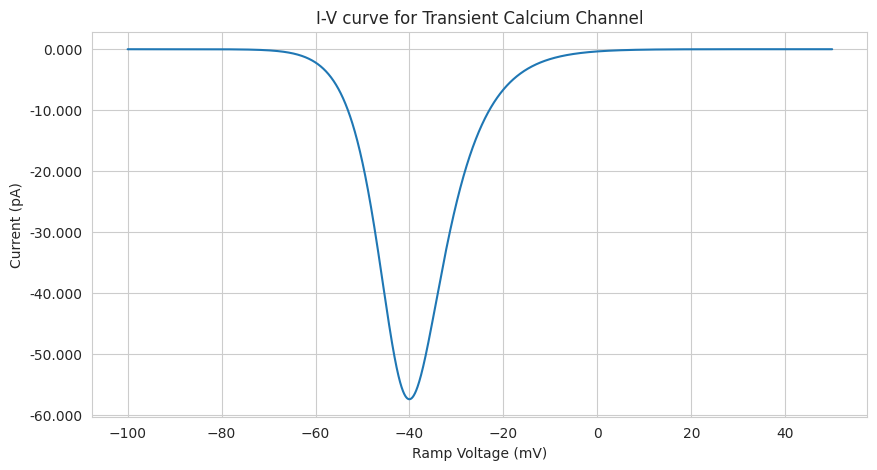

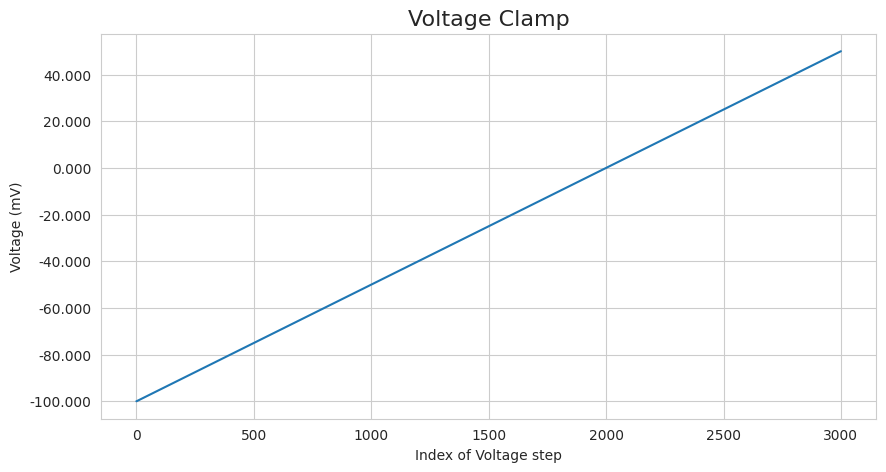

In [3]:
plot_iv_curves_ramp([Ca_T(v_rest_global=-80)],
                    v_start=-100,
                    v_end=50,
                    v_step_increase = 0.05,
                    measurements_per_step = 1,
                    title_str = "I-V curve for Transient Calcium Channel")

In [4]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from typing import List

import jaxley as jx

def plot_iv_curves(channels: List[jx.channels], 
                   v_holding: float,
                   v_step_values: List[float],
                   dt: float = 0.5,
                   title_str: str = None) -> None:
    """
    Plot I-V curves for a list of channels by setting a holding voltage and
    then applying a step voltage. The maximum current is recorded and plotted.
    
    channels: List[jx.channels]     - List of channels to plot I-V curves for
    v_holding: float                - Holding voltage in mV
    v_step_values: List[float]      - List of step voltage values
    dt: float                       - Time step of the simulation in ms
    title_str: str                  - Title of the figure
    """
    
    # Define constants
    v_step_on_time = 500
    v_step_duration = 2000
    total_time = 5000
    padding_time = 10
    
    # Calculate the padding steps
    padding_steps = int(padding_time / dt)

    # Calculate the total time with padding
    total_time_pad = total_time + 2 * padding_time

    # Create the time vector
    time_steps = int(total_time_pad / dt)

    # Initialize the cell and its components
    compartment = jx.Compartment()
    branch = jx.Branch(compartment, nseg=1)
    cell = jx.Cell(branch, parents=[-1])

    # Set the parameters of the cell
    params = {
        "length": 5.,
        "radius": 2.5,
        "capacitance": 10,
        "v": v_holding
    }

    # Set the parameters of the cell
    for name, param in params.items():
        cell.set(name, param)
    
    # Initialize the variables to record, always record the membrane potential
    to_records = ['v']
    # Insert the channels and initialize their states
    for channel in channels:
        # Insert the channel and initialize its states
        cell.insert(channel)
        cell.init_states()

        # Get the prefix of the channel
        prefix = channel._name

        # Collect the current names to record. Don't record the
        # CaPump and CaNernstReversal
        if (prefix != 'CaPump') and (prefix != 'CaNernstReversal'):
            # Get the current name and states of the channel
            current_name = channel.current_name
            # Which variables to record
            to_records += [current_name]
        
    # Initialize the array to store the maximum currents
    max_currents = np.zeros((len(channels), len(v_step_values)))

    # Loop over all the step voltage values
    for idx_v_step, v_step_value in enumerate(v_step_values):

        # Create step voltage array, add the padding and apply the step voltage
        v = jnp.zeros(time_steps) + v_holding
        v_step_on = int(v_step_on_time / dt)
        v_step_off = int((v_step_on_time + v_step_duration) / dt)
        v = v.at[v_step_on:v_step_off].set(v_step_value)
        v = jnp.pad(v, (padding_steps, padding_steps), 'edge')

        # Delete recordings and stimuli
        cell.delete_recordings()
        cell.delete_stimuli()

        # Apply voltage clamp
        cell.clamp('v', v, False)

        # Record variables
        for rec in to_records:
            cell.record(rec, verbose=False)  # Deactivate verbose

        # Integrate the cell model
        s = jx.integrate(cell, delta_t=dt, t_max=total_time_pad)
        s = prettify(s, to_records, dt)   

        # Remove padding for plotting and adjust time array, watch out for the indexing
        s_pad = {}
        s_pad['time'] = s['time'][padding_steps+1:-padding_steps] - padding_time
        for rec in to_records:
            s_pad[rec] = s[rec][padding_steps+1:-padding_steps]

        # Adjust the step onset index for the padding
        step_onset_index = v_step_on - padding_steps
        step_offset_index = v_step_off - padding_steps

        # Get the maximum current for each channel, exclude the first record which is the membrane potential
        for i, rec in enumerate(to_records[1:]):
            if 'i' in rec:
                # Find the index of the maximum current. Ensure that the maximum current is identified
                # only after the step voltage is applied, and not during the initial holding phase.
                max_current_index = np.argmax(np.abs(s_pad[rec][step_onset_index:step_offset_index])) + step_onset_index
                
                # Convert nA to pA by multiplying with 1e3
                s_pad[rec] = s_pad[rec] * 1e3
                
                # Find the maximum current
                max_current = s_pad[rec][max_current_index]
                    
                # Append the maximum current to the array
                max_currents[i, idx_v_step] = max_current

    # Create a single figure and axes for all conditions
    if len(channels) == 1:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax = [ax]  # Make it iterable
    else:
        fig, ax = plt.subplots(1, len(channels), figsize=(10, 5*len(channels)))

    # Loop over all the channels
    for idx_channel, channel in enumerate(channels):
        # Find the indices where the current changes sign
        sign_changes = np.where(np.diff(np.sign(max_currents[idx_channel,:])))[0]
        equilibrium_potential = None

        # If there are sign changes, calculate the equilibrium potential
        if len(sign_changes) > 0:
            # The equilibrium potential is the average of the two holding voltages where the current changes sign
            equilibrium_potential = (v_step_values[sign_changes[0]] + v_step_values[sign_changes[0] + 1]) / 2

        # Plot the I-V curve for the current channel
        ax[idx_channel].plot(v_step_values, max_currents[idx_channel, :], marker='o', linestyle='-', label=f'Max {current_name}')
        if equilibrium_potential is not None:
            ax[idx_channel].axvline(equilibrium_potential, color='r', linestyle='--', label=f'Equilibrium: {equilibrium_potential:.2f} mV')
        ax[idx_channel].set_xlabel('Step Voltage (mV)')
        ax[idx_channel].set_ylabel('Maximum Current (pA)')
        if len(channels) > 1:
            ax[idx_channel].legend()
        if title_str is not None:
            ax[idx_channel].set_title(f'{title_str}')
        else:
            ax[idx_channel].set_title(f'I-V Curve for Max {current_name}', fontsize=16)
        
        # Ensure y-axis does not use scientific notation
        ax[idx_channel].yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
        ax[idx_channel].xaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
        ax[idx_channel].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))


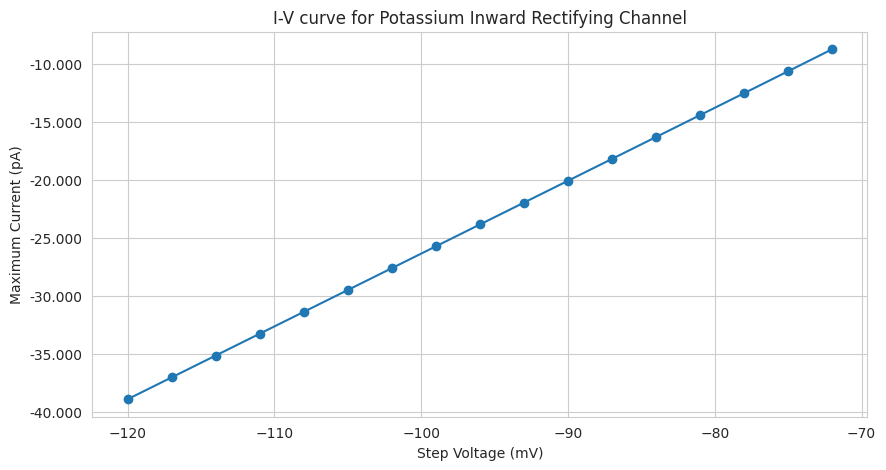

In [5]:
# Plot an I-V curve for the K_IR channel
plot_iv_curves(channels = [K_IR(v_rest_global=-60)],
                v_holding= -60,
                v_step_values = np.arange(-120, -71, 3),  
                dt = 0.5,
                title_str = 'I-V curve for Potassium Inward Rectifying Channel')